### Test a trained model

In [ ]:
# save files in drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Import libs
import os 
import time
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import optimizers
import keras
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model
from keras.models import Sequential
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.utils import np_utils
from imgaug import augmenters as iaa    
import itertools
import pickle
import umap
import time
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(42)


# Experiment name
#########################################################################################
exp_list = ["b2m_510_2nd", "1_vgg_baseline", "2_vgg_offline_aug", "3_vgg_offline_aug_10x", "4_gan_100"] # 571
EXP_NAME = exp_list[-1]
#########################################################################################

# Define paths
base_path = os.path.abspath("gdrive/My Drive/melanoma/")
dataset_path = os.path.join(base_path, "dataset", "isic2016numpy")
print("Contents in folder:", os.listdir(dataset_path))

# Set output path
output_path = os.path.join(base_path, EXP_NAME)
print(output_path)


# Print version
print("Keras Version", keras.__version__)
print("Tensorflow Version", tf.__version__)

# GPU test
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

# Helpers
def save_obj(obj, name):
    with open('{}'.format(base_path) + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open('{}'.format(base_path) + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def get_unique(arr):
  '''
  Return unique elements in list
  '''
  arr = set(arr)
  return arr


print(get_available_gpus())

# Get compute specs
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

# Load test data
x_test = np.load("{}/x_test.npy".format(dataset_path))
y_test = np.load("{}/y_test.npy".format(dataset_path))

# Standardize
x_test = x_test.astype('float32')
x_test /= 255
assert min(x_test.flatten()) == 0.0, "Not preprocessed"

# Show shape
print("Dataset sample size :", x_test.shape, y_test.shape)


# Model path
weights_path = "{}/{}.h5".format(output_path, EXP_NAME)
model = load_model(weights_path, compile = False) 
print("Model loaded")


# Make predictions using trained model
y_pred = model.predict(x_test, verbose=1)
print("Predictions: ", y_pred.shape)


# Convert ground truth to column values
y_test_flat = np.argmax(y_test, axis=1)
print("After flattening ground truth: ", y_test_flat.shape)


# Get labels from predictions
y_pred_flat = np.array([np.argmax(pred) for pred in y_pred]) # y_pred[1] -> probability for class 1 
print("Binarize probability values: ", y_pred_flat.shape)

assert y_pred_flat.shape == y_test_flat.shape, "Shape mismatch!"

Using TensorFlow backend.


Contents in folder: ['y_test.npy', 'x_test.npy', 'y_gan_100.npy', 'x_gan_100.npy', 'x_train.npy', 'y_train.npy', 'y_b2m_370.npy', 'x_b2m_370.npy', 'y_b2m_510.npy', 'x_b2m_510.npy', 'y_b2m_597.npy', 'x_b2m_597.npy', 'y_b2m_571.npy', 'x_b2m_571.npy', 'y_UMAPb2m_510.npy', 'x_UMAPb2m_510.npy']
/content/gdrive/My Drive/melanoma/4_gan_100
Keras Version 2.2.5
Tensorflow Version 1.15.0
['/device:GPU:0']
Dataset sample size : (379, 256, 256, 3) (379, 2)









Model loaded
379/379 [==============================] - 7s 18ms/step
Predictions:  (379, 2)
After flattening ground truth:  (379,)
Binarize probability values:  (379,)


In [ ]:
# Sanity check
print(y_test.shape, y_test_flat.shape, y_pred.shape, y_pred_flat.shape)

(379, 2) (379,) (379, 2) (379,)


In [ ]:
# Accuracy

acc = accuracy_score(y_test_flat, y_pred_flat) * 100
print("Accuracy :", acc)

Accuracy : 83.11345646437994


In [ ]:
# Average precision

from sklearn.metrics import average_precision_score
ap = average_precision_score(y_test, y_pred) * 100
print("Average precision :", ap)

Average precision : 75.62221928373636


In [ ]:
# Classification report

confusion_mtx = confusion_matrix(y_test_flat, y_pred_flat) 
print(confusion_mtx)
target_names = ['0', '1']
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names))

[[282  22]
 [ 42  33]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       304
           1       0.60      0.44      0.51        75

    accuracy                           0.83       379
   macro avg       0.74      0.68      0.70       379
weighted avg       0.82      0.83      0.82       379



Confusion Matrix
[[282  22]
 [ 42  33]]


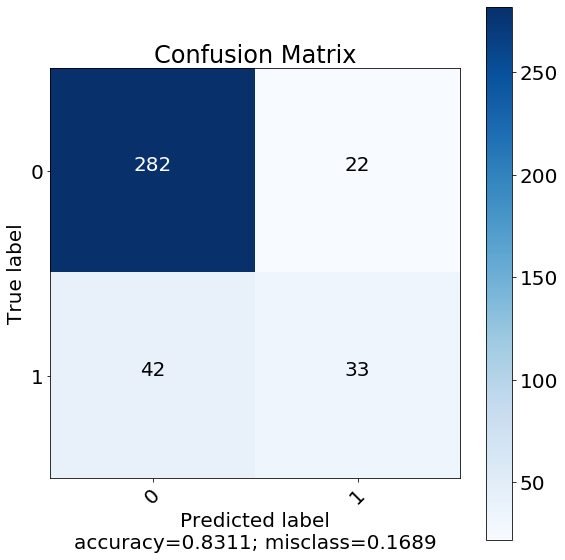

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_flat,y_pred_flat)

labels = ['0', '1']
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(8,8))

# plot CF fancy image
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [ ]:
# Sensitivity and Specificity

cm = confusion_matrix(y_pred=y_pred_flat, y_true=y_test_flat)
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  87.03703703703704
Specificity :  60.0


In [ ]:
y_pred[:10], y_test[:10]

(array([[0.6989634 , 0.3010366 ],
        [0.7348446 , 0.26515535],
        [0.46917892, 0.5308211 ],
        [0.62177914, 0.37822083],
        [0.6918412 , 0.30815884],
        [0.72653896, 0.27346104],
        [0.7726322 , 0.22736779],
        [0.6877689 , 0.31223112],
        [0.77277267, 0.22722729],
        [0.22920035, 0.77079964]], dtype=float32), array([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]], dtype=float32))

In [ ]:
#pred_y = np.array([x[1] for x in y_pred])
#pred_y.shape
#pred_y[:10], y_test_flat[:10]

In [ ]:
from sklearn.metrics import roc_auc_score
print('Area under ROC curve : ', roc_auc_score(y_test, y_pred) *100 )

Area under ROC curve :  79.33333333333333


Area under the ROC curve for positive class: 0.7933333333333333


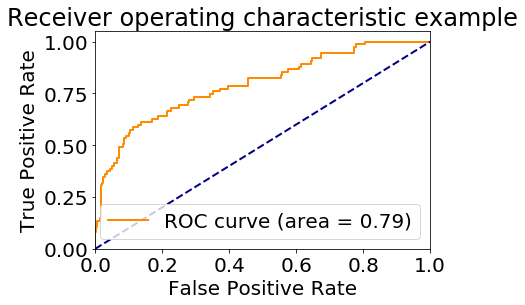

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
cls = 1 # class name
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#print(roc_auc)
print("Area under the ROC curve for positive class:", roc_auc[1])


plt.figure()
lw = 2 # line width
plt.plot(fpr[cls], tpr[cls], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Save AUCROC for plotting
#ascore = {}
#ascore["fpr"] = fpr[cls]
#ascore["tpr"] = tpr[cls]
#ascore["roc_auc"] = roc_auc[cls]
#save_obj(ascore, EXP_NAME)

#type(fpr[cls]), roc_auc[cls]

### t-SNE

In [ ]:
titles = ['VGG-GAP Baseline', 'VGG-GAP + Augment-5x', 'VGG-GAP + Augment-10x', 'VGG-GAP + MeGAN']

predicts = np.vstack(y_pred_flat)
classes = np.hstack(y_test_flat)
predicts.shape, classes.shape

classes_cat = []

for c in classes:
  if c==0:
    classes_cat.append("Benign")
  else:
    classes_cat.append("Malignant")

len(classes_cat)

379

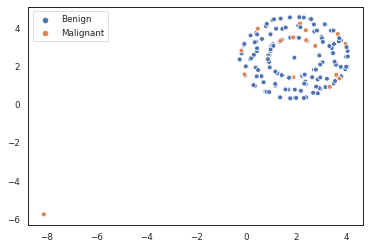

In [ ]:
import seaborn
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=2)
tsne_data = tsne.fit_transform(predicts)

seaborn.scatterplot(tsne_data[:,0], tsne_data[:,1], hue=classes_cat)
#plt.savefig("{}/{}_tSNE.pdf".format(base_path, EXP_NAME), dpi=300)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 379 samples in 0.001s...
[t-SNE] Computed neighbors for 379 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 379 / 379
[t-SNE] Mean sigma: 0.010612
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.739624
[t-SNE] KL divergence after 1000 iterations: 0.133627


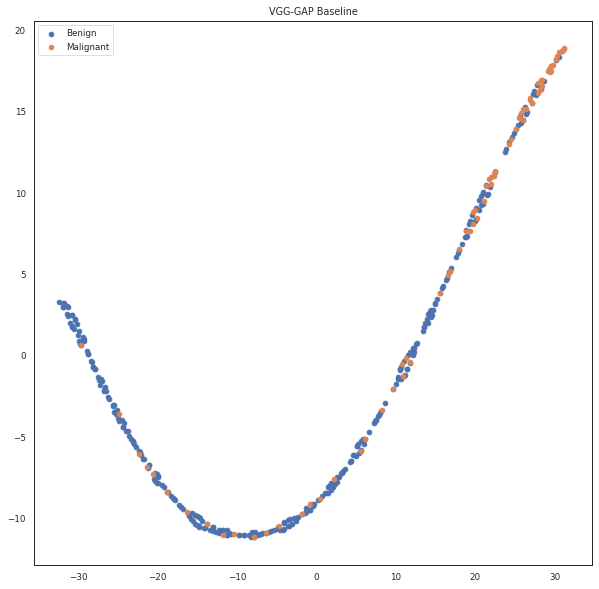

In [ ]:
from sklearn.decomposition import PCA

predictions = y_pred

# Run t-SNE on the PCA results to obtain a 2D plot
tsne = TSNE(n_components=2, perplexity=30, learning_rate=250, random_state = 2, verbose = 1)
tsne_results = tsne.fit_transform(predictions)

# Convert to binary class matrix
categoricalClasses = np_utils.to_categorical(y_test_flat, num_classes = 2)

# Create a figure where each class has a unique colour
colour_map = np.argmax(categoricalClasses, axis=1)
tsneFigure = plt.figure(figsize=(10,10))
for colour in range(2):
    indices = np.where(colour_map==colour)
    indices = indices[0]
    
    if colour == 0:
      l = "Benign"
    else:
      l = "Malignant"

    plt.scatter(tsne_results[indices,0],
                tsne_results[indices,1],
                label=l)
  
plt.legend()
plt.title(titles[0]) #t-SNE Visualisation
#plt.savefig("{}/{}_tSNE.pdf".format(base_path, EXP_NAME), dpi=300)
plt.show()

### GradCAM

In [ ]:
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'th': #keras.backend.image_data_format()
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)


def get_heatmap(gc):
  """Convert 2D heatmap to 3D for plotting"""
  # Get the color map
  cm = plt.get_cmap('jet')
  # Apply the colormap like a function to any array:
  gc3 = cm(gc)
  gc3 = gc3[:, :, :3].astype('float32') 
  return gc3

def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (256, 256), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

In [ ]:
#ct = 19 #random.randrange(256)
#img = np.expand_dims(x_test[ct], axis=0)
#print("Image number: ", ct)
#print("Image shape: ", img.shape)
#print("True Label: ", y_test_flat[ct])
#print("Precited Label: ", y_pred_flat[ct])
#plt.imshow(x_test[ct])

# GradCAM
#gc = grad_cam(model, img, -1, 'block5_conv3')
#print(gc.shape)

# Plot gradcam
#plt.imshow(gc)

# Plot both image and gradcam
#plt.imshow(x_test[ct])
#plt.imshow(gc, cmap='jet', alpha=0.4)

  0%|          | 0/10 [00:00<?, ?it/s]

Number of missclassified samples: (10, 256, 256, 3)


100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Number of missclassified gradcam samples: (10, 256, 256, 3)


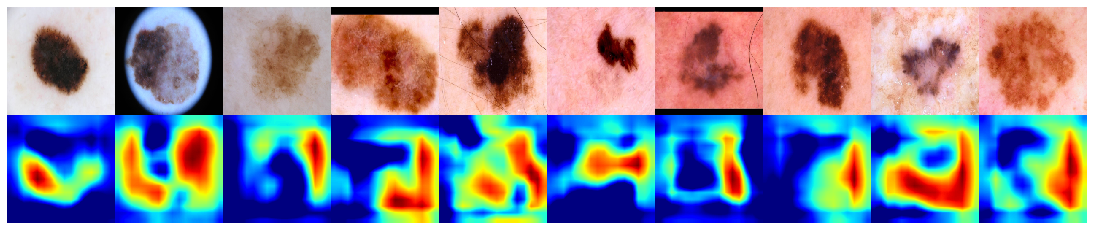

In [ ]:
missclass_1 = []

for i in tqdm(range(len(y_test_flat))):
  # if predicted is 0 and actual is 1
  if y_pred_flat[i] == 0 and y_test_flat[i] == 1:
    missclass_1.append(x_test[i])

# take first 10 missclassified sampels
missclass_1 = np.array(missclass_1[:10])

print("Number of missclassified samples:", missclass_1.shape)


missclass_1_gcam = []

for ms in tqdm(missclass_1):

  ms = np.expand_dims(ms, axis=0)
  # grad cam
  gc = grad_cam(model, ms, -1, 'block5_conv3')
  # convert to 3D
  gc = get_heatmap(gc)
  missclass_1_gcam.append(gc)

missclass_1_gcam = np.array(missclass_1_gcam)

print("Number of missclassified gradcam samples:", missclass_1_gcam.shape)


from numpy.random import rand
import matplotlib.pyplot as plt

results = np.concatenate((missclass_1, missclass_1_gcam), axis=0)

x = results
a, b = 2, 10
x = np.reshape(x, (a, b, 256, 256, 3))

test_data = x
r, c = test_data.shape[0], test_data.shape[1]
cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

heights = [a[0].shape[0] for a in test_data]
widths = [a.shape[1] for a in test_data[0]]

fig_width = 15.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(r):
    for j in range(c):
        axarr[i, j].imshow(test_data[i][j])
        axarr[i, j].axis('off')

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.savefig("{}/{}_right_1gradcam.png".format(base_path, EXP_NAME), dpi=300)
plt.show()

In [ ]:
# https://umap-learn.readthedocs.io/en/latest/auto_examples/plot_mnist_example.html
!pip install umap-learn

### UMAP

In [ ]:
# Load raw training data and labels

raw_train = np.load("{}/x_train.npy".format(dataset_path))
print(raw_train.shape)

raw_t_s = np.array([img.flatten() for img in raw_train])
print(raw_t_s.shape)

raw_annot = np.load("{}/y_train.npy".format(dataset_path))
print(raw_annot.shape)

raw_annot_flat = np.argmax(raw_annot, axis=1)
print(raw_annot_flat.shape)

(900, 256, 256, 3)
(900, 196608)
(900, 2)
(900,)


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


<Figure size 864x720 with 0 Axes>

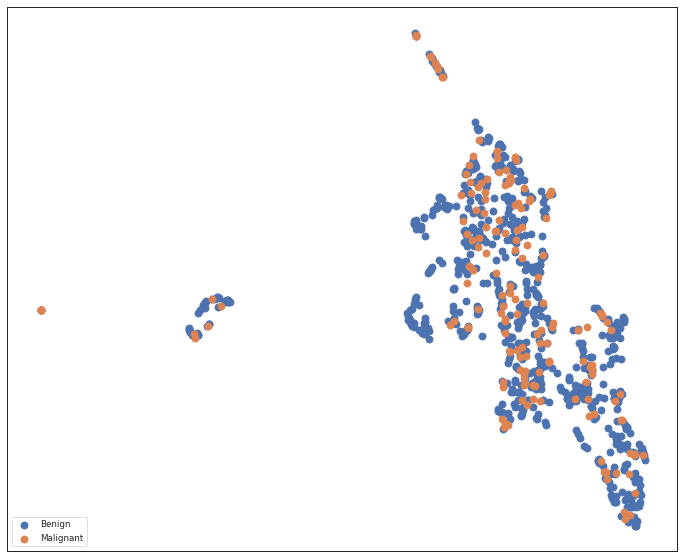

In [ ]:
import umap
import time
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

data = raw_t_s

reducer = umap.UMAP(n_neighbors=5, random_state=42)
embedding = reducer.fit_transform(data)

#fig, ax = plt.subplots(figsize=(12, 10))
#color = raw_annot_flat.astype(int) # mnist.target.astype(int)

#plt.scatter(
#    embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=100
#)

#plt.setp(ax, xticks=[], yticks=[])
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks([0, 1])
#plt.title("Data embedded into two dimensions by UMAP", fontsize=18)
#plt.savefig("{}/{}_raw.pdf".format(base_path, "umap"), dpi=300)
#plt.show()


colour_map = raw_annot_flat

tsneFigure = plt.figure(figsize=(12,10))
fig, ax = plt.subplots(figsize=(12, 10))

for colour in range(2):
    indices = np.where(colour_map==colour)
    indices = indices[0]
    
    if colour == 0:
      l = "Benign"
    if colour == 1:
      l = "Malignant"
    if colour == 2:
      l = "Generated Malignant"

    plt.setp(ax, xticks=[], yticks=[])
    plt.scatter(embedding[:, 0][indices],
                embedding[:, 1][indices],
                label=l, cmap="Spectral", s=50)
    
plt.legend(loc='lower left')
plt.savefig("{}/{}_raw.pdf".format(base_path, "umap"), dpi=300)
plt.show()

In [ ]:
# Load raw+synthetic data and labels

raw_train = np.load("{}/x_b2m_510.npy".format(dataset_path)) #x_gan_100, x_UMAPb2m_510
print(raw_train.shape)

raw_t_s = np.array([img.flatten() for img in raw_train])
print(raw_t_s.shape)


raw_annot = np.load("{}/y_b2m_510.npy".format(dataset_path))
print(raw_annot.shape)

raw_annot_flat = np.argmax(raw_annot, axis=1)
print(raw_annot_flat.shape)

(1627, 256, 256, 3)
(1627, 196608)
(1627, 2)
(1627,)


In [ ]:
raw_annot_flat_3 = []

count = 0
for i in range(len(raw_annot_flat)):  
  if count == 700:
    raw_annot_flat_3.append(raw_annot_flat[i])
    pass
  else:
    if raw_annot_flat[i] == 1:
      raw_annot_flat_3.append(2)
      count+=1
    else:
      raw_annot_flat_3.append(raw_annot_flat[i])
    
raw_annot_flat_3 = np.array(raw_annot_flat_3)
print(raw_annot_flat_3[:20])
print(raw_annot_flat_3.shape)
print(len(raw_annot_flat_3))
print(np.unique(raw_annot_flat_3))

[2 2 2 2 2 0 2 2 2 2 2 0 2 2 0 0 2 2 2 0]
(1627,)
1627
[0 1 2]


In [ ]:
# Load raw+synthetic data and labels

#raw_train = np.load("{}/x_UMAPb2m_510.npy".format(dataset_path))
#print(raw_train.shape)

#raw_t_s = np.array([img.flatten() for img in raw_train])
#print(raw_t_s.shape)

#raw_annot = np.load("{}/y_UMAPb2m_510.npy".format(dataset_path))
#print(raw_annot.shape)

#raw_annot_flat = np.argmax(raw_annot, axis=1)
#print(raw_annot_flat.shape)


#raw_annot_flat_3 = raw_annot_flat
#raw_t_s.shape, raw_annot_flat_3.shape

<Figure size 864x720 with 0 Axes>

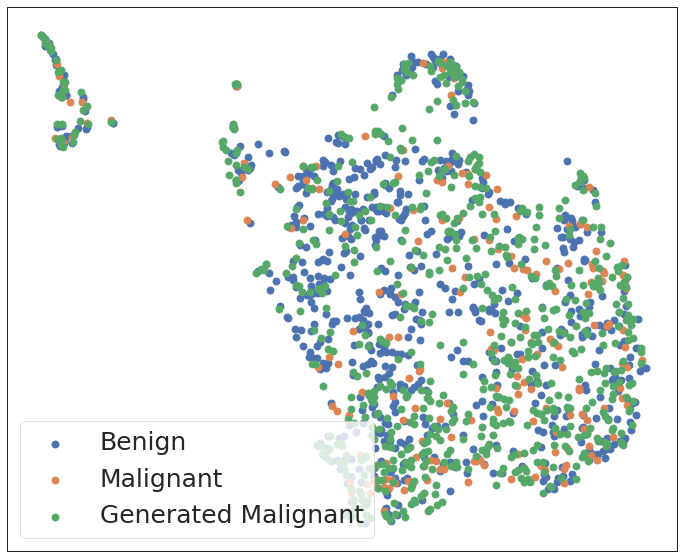

In [ ]:
import umap
import time
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

data = raw_t_s

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(data)

#fig, ax = plt.subplots(figsize=(12, 10))
#color = raw_annot_flat_3.astype(int) # mnist.target.astype(int)

#plt.scatter(
#    embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=100
#)

#plt.setp(ax, xticks=[], yticks=[])
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks([0, 1])
#plt.title("Data embedded into two dimensions by UMAP", fontsize=18)
#plt.savefig("{}/{}_gan_2.pdf".format(base_path, "umap"), dpi=300)
#plt.show()


colour_map = raw_annot_flat_3 #raw_annot_flat

tsneFigure = plt.figure(figsize=(12,10))
fig, ax = plt.subplots(figsize=(12, 10))

for colour in range(3):
    indices = np.where(colour_map==colour)
    indices = indices[0]
    
    if colour == 0:
      l = "Benign"
    if colour == 1:
      l = "Malignant"
    if colour == 2:
      l = "Generated Malignant"

    plt.setp(ax, xticks=[], yticks=[])
    plt.scatter(embedding[:, 0][indices],
                embedding[:, 1][indices],
                label=l, cmap="Spectral", s=50)
    
 
plt.legend(loc='lower left', prop={'size': 25})
#plt.savefig("{}/{}_gan.pdf".format(base_path, "umap"), dpi=1000)
plt.show()

In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, y_train.shape

11493376/11490434 [==============================] - 1s 0us/step


((60000, 28, 28), (60000,))